In [ ]:
# import kaggle

# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('elvis23/mental-health-conversational-data', path='.', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/elvis23/mental-health-conversational-data


In [141]:
import json
import pandas as pd

with open('intents.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['intents'])

In [158]:
dic = {"tag":[], "patterns":[], "responses":[]}
for i in range(len(df)):
    ptrns = df[df.index == i]['patterns'].values[0]
    rspns = df[df.index == i]['responses'].values[0]
    tag = df[df.index == i]['tag'].values[0]
    for j in range(len(ptrns)):
        dic['tag'].append(tag)
        dic['patterns'].append(ptrns[j])
        dic['responses'].append(rspns)
        
df = pd.DataFrame.from_dict(dic)
df

KeyError: 'patterns'

In [143]:
df_responses = df.explode('responses')
all_patterns = ' '.join(df['patterns'])

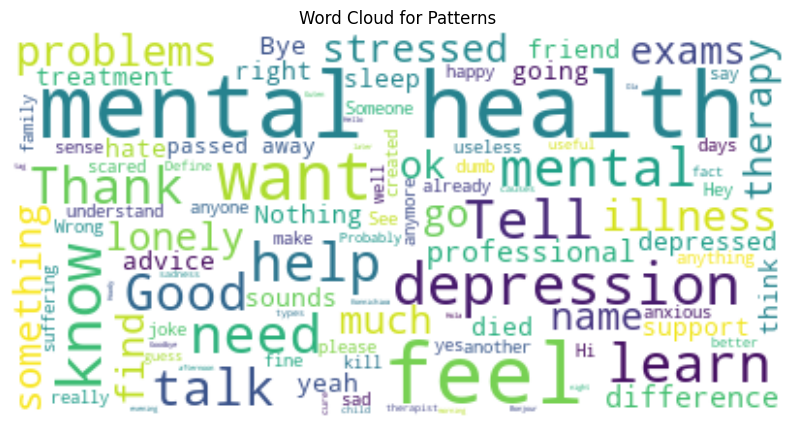

In [144]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue').generate(all_patterns)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Patterns')
plt.show()

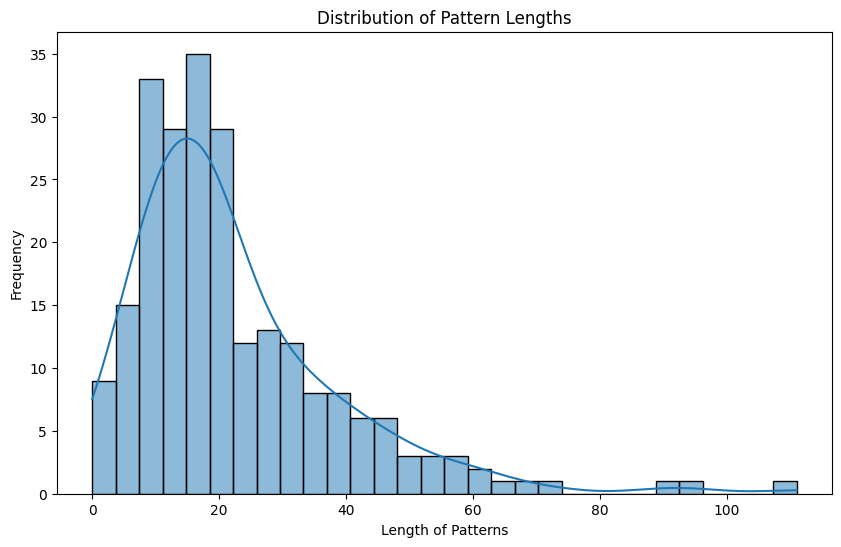

In [145]:
df['pattern_length'] = df['patterns'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['pattern_length'], bins=30, kde=True)
plt.title('Distribution of Pattern Lengths')
plt.xlabel('Length of Patterns')
plt.ylabel('Frequency')
plt.show()

In [146]:
import re

def preprocess_text(s):
    s = re.sub('[^a-zA-Z\']', ' ', s) 
    s = s.lower()
    s = s.split()
    s = " ".join(s)
    return s

df['patterns'] = df['patterns'].apply(preprocess_text)
df['tag'] = df['tag'].apply(preprocess_text)
df

,tag,patterns,responses,pattern_length
0,greeting,hi,[Hello there. Tell me how are you feeling toda...,2
1,greeting,hey,[Hello there. Tell me how are you feeling toda...,3
2,greeting,is anyone there,[Hello there. Tell me how are you feeling toda...,16
3,greeting,hi there,[Hello there. Tell me how are you feeling toda...,8
4,greeting,hello,[Hello there. Tell me how are you feeling toda...,5
...,...,...,...,...
227,fact,how do i know if i'm unwell,"[If your beliefs , thoughts , feelings or beha...",28
228,fact,how can i maintain social connections what if ...,"[A lot of people are alone right now, but we d...",61
229,fact,what's the difference between anxiety and stress,[Stress and anxiety are often used interchange...,49
230,fact,what's the difference between sadness and depr...,"[Sadness is a normal reaction to a loss, disap...",53


In [147]:
df['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'no response', 'neutral response', 'about', 'skill',
       'creation', 'name', 'help', 'sad', 'stressed', 'worthless',
       'depressed', 'happy', 'casual', 'anxious', 'not talking', 'sleep',
       'scared', 'death', 'understand', 'done', 'suicide', 'hate you',
       'hate me', 'default', 'jokes', 'repeat', 'wrong', 'stupid',
       'location', 'something else', 'friends', 'ask', 'problem',
       'no approach', 'learn more', 'user agree', 'meditation',
       'user meditation', 'pandora useful', 'user advice',
       'learn mental health', 'mental health fact', 'fact'], dtype=object)

In [148]:
len(df['tag'].unique())

50

In [149]:
X = df['patterns']
y = df['tag']

In [150]:
y

0      greeting
1      greeting
2      greeting
3      greeting
4      greeting
         ...   
227        fact
228        fact
229        fact
230        fact
231        fact
Name: tag, Length: 232, dtype: object

# PRE PROCESSING INDO

In [151]:
import numpy as np
import pandas as pd
import nltk
import random
import json
import re
import string
import itertools

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ALMIRA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [152]:
import nltk
nltk.download('punkt')

nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ALMIRA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALMIRA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [153]:
import json
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# 1. Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

# 2. Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# 3. Load your intents.json
with open("intents.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# 4. Flatten data
rows = []
for intent in data["intents"]:
    tag = intent["tag"]
    patterns = intent["patterns"]
    responses = intent["responses"]

    for pattern in patterns:
        for response in responses:
            rows.append({
                "intent": tag,
                "pattern": pattern,
                "response": response
            })

df = pd.DataFrame(rows)

# 5. Text preprocessing function
def preprocess_text(text):
    text = text.lower()                            # lowercase
    text = re.sub(r"[^\w\s]", " ", text)           # remove punctuation
    words = text.split()
    words = [w for w in words if w not in stop_words]  # remove stopwords
    text = ' '.join(words)
    stemmed = stemmer.stem(text)                   # stemming
    return stemmed.strip()

# 6. Apply preprocessing
df["pattern_clean"] = df["pattern"].apply(preprocess_text)
df["response_clean"] = df["response"].apply(preprocess_text)

# 7. Show result
print(df[["intent", "pattern", "pattern_clean", "response_clean"]].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALMIRA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     intent pattern pattern_clean  \
0  greeting      Hi            hi   
1  greeting      Hi            hi   
2  greeting      Hi            hi   
3  greeting      Hi            hi   
4  greeting      Hi            hi   

                                      response_clean  
0      hello there tell me how are you feeling today  
1                hi there what brings you here today  
2                 hi there how are you feeling today  
3         great to see you how do you feel currently  
4  hello there glad to see you re back what s goi...  


# Build Model

In [154]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [155]:
# Tokenization and Encoding the Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128 

def encode_texts(texts, max_len):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',      
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

In [156]:
# Encoding labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_labels = len(np.unique(y_encoded))

# Encode the patterns
input_ids, attention_masks = encode_texts(X, max_len)
labels = torch.tensor(y_encoded)

# Splitting the dataset into training and validation
dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
validation_dataloader = DataLoader(val_dataset, batch_size=16)

# Model and Optimization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [157]:
# training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        model.zero_grad()        
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_train_loss:.2f}")

KeyboardInterrupt: 

# Model Evaluation